In [1]:
import gzip, struct
import numpy as np

def _read(image,label):
    minist_dir = './data/'
    with gzip.open(minist_dir+label) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(minist_dir+image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return image,label

def get_data():
    train_img,train_label = _read(
            'train-images-idx3-ubyte.gz', 
            'train-labels-idx1-ubyte.gz')
    test_img,test_label = _read(
            't10k-images-idx3-ubyte.gz', 
            't10k-labels-idx1-ubyte.gz')
    return [train_img,train_label,test_img,test_label]

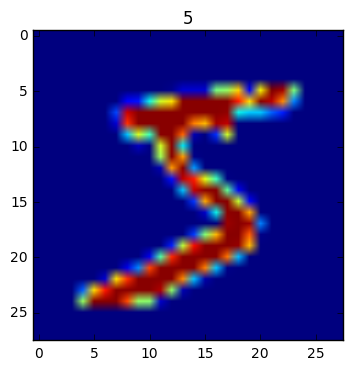

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

X, y, Xt, yt = get_data()
def imshow(img, label):
    plt.imshow(img.reshape((28,28)))
    plt.title(label)

imshow(X[0], y[0])

In [3]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

import torch
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
#使用pytorch封装的dataloader进行训练和预测
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms


def custom_normalization(data, std, mean):
    return (data - mean) / std

use_gpu = torch.cuda.is_available()
    
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True} if use_gpu else {}

X, y, Xt, yt = get_data()
#主要进行标准化处理
mean, std = X.mean(), X.std()
X = custom_normlization(X, mean, std)
Xt = custom_normlization(Xt, mean, std)

train_x, train_y = torch.from_numpy(X.reshape(-1, 1, 28, 28)).float(), torch.from_numpy(y.astype(int))
test_x, test_y = [
    torch.from_numpy(Xt.reshape(-1, 1, 28, 28)).float(),
    torch.from_numpy(yt.astype(int))
    ]

train_dataset = TensorDataset(data_tensor=train_x, target_tensor=train_y)
test_dataset = TensorDataset(data_tensor=test_x, target_tensor=test_y)


train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, **kwargs)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=batch_size, **kwargs)

model = LeNet5()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def weight_init(m):
# 使用isinstance来判断m属于什么类型
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
# m中的weight，bias其实都是Variable，为了能学习参数以及后向传播
        m.weight.data.fill_(1)
        m.bias.data.zero_()

model.apply(weight_init)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



for epoch in range(1, 501):
    train(epoch)
    test()

USE GPU
Train Epoch: 1 [0/60000 (0%)]	Loss: 595.124817
Train Epoch: 1 [25600/60000 (43%)]	Loss: 152.273407
Train Epoch: 1 [51200/60000 (85%)]	Loss: 28.779629

Test set: Average loss: 0.0872, Accuracy: 9738/10000 (97.38%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 25.694176
Train Epoch: 2 [25600/60000 (43%)]	Loss: 23.661152
Train Epoch: 2 [51200/60000 (85%)]	Loss: 29.156540

Test set: Average loss: 0.0595, Accuracy: 9814/10000 (98.14%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 16.024918
Train Epoch: 3 [25600/60000 (43%)]	Loss: 11.336308
Train Epoch: 3 [51200/60000 (85%)]	Loss: 17.372978

Test set: Average loss: 0.0459, Accuracy: 9849/10000 (98.49%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 5.856915
Train Epoch: 4 [25600/60000 (43%)]	Loss: 10.274417
Train Epoch: 4 [51200/60000 (85%)]	Loss: 9.624058

Test set: Average loss: 0.0430, Accuracy: 9876/10000 (98.76%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 6.784124
Train Epoch: 5 [25600/60000 (43%)]	Loss: 5.686603
Train Epoch: 5 [51200/60000 (85%)]	Loss: 8.853918

Process Process-1618:
Process Process-1617:
Traceback (most recent call last):
  File "/home/lx/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/lx/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lx/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/lx/anaconda3/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/lx/anaconda3/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/lx/anaconda3/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/lx/anaconda3/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most 

Train Epoch: 405 [25600/60000 (43%)]	Loss: 590.585815


KeyboardInterrupt: 

In [ ]:
#自定义训练预测

print('Loading data')
X, y, Xt, yt = get_data()
X, Xt = torch.from_numpy(X.reshape(-1, 1, 28, 28)), torch.from_numpy(Xt.reshape(-1, 1, 28, 28))
y, yt = torch.from_numpy(y.astype(float)), torch.from_numpy(yt.astype(float))

print(X.size(), y.size())

model = LeNet5()
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    
    batch_size = 256
    
    for inx in range(int(X.shape[0]/batch_size)):
        start_inx = inx * batch_size
        end_inx = min((inx+1)*batch_size, X.shape[0])
        mini_data = Variable(X[start_inx:end_inx].clone())
        mini_label = Variable(y[start_inx:end_inx].clone())
        mini_data = mini_data.type(torch.FloatTensor)
        mini_label = mini_label.type(torch.LongTensor)
        if use_gpu:
            mini_data = mini_data.cuda()
            mini_label = mini_label.cuda()
        optimizer.zero_grad()
        mini_out = model(mini_data)
        mini_label = mini_label.view(end_inx-start_inx)
#         print(mini_out.size(), mini_label.size())
        mini_loss = criterion(mini_out, mini_label)
        mini_loss.backward()
        optimizer.step()
        
        if inx % 50 == 0:
            print('Train Epoch: {}/{}*256 loss is {:.4f}'.format(epoch, inx, mini_loss.data[0]))

def test():
    model.eval()
    test_loss = 0.

    correct = 0.
    nb_test = Xt.shape[0]
    for each_sample in range(nb_test):
        sample_data = Variable(Xt[each_sample:each_sample+1].clone(), volatile=True)
        sample_data = sample_data.type(torch.FloatTensor)
        sample_label = Variable(yt[each_sample:each_sample+1].clone())
        sample_label = sample_label.type(torch.LongTensor)
        if use_gpu:
            sample_data = sample_data.cuda()
            sample_label = sample_label.cuda()
            
        sample_out = model(sample_data)
        
        test_loss += criterion(sample_out, sample_label)
        
        pred = sample_out.data.max(1, keepdim=True)[1]
        correct += pred.eq(sample_label.data.view_as(pred)).cpu().sum()
    loss =  (test_loss / nb_test).data[0]
    acc = 100. * correct / nb_test
    print('Test set: Avg Loss: {:.4f}, Accuracy: {}/{}({:.2f}%)'.format(loss, correct, nb_test, acc))
    
for epoch in range(2):
    train(epoch)
    test()

In [10]:
torch.utils.data.DataLoader?